## Laboratoire 2
**Equipe 1** 



Membres: Kevin Chenier, Jeremie Bellegarde, Sebastien René


## Introduction

 Pour ce laboratoire, nous devons choisir 8 classes pour créer un ensemble d'images qui pourront être reconnu grâce aux notions que nous avons apprisent en classe.
 Pour ce faire, nous utiliserons Jupyter Notebook afin de séparer clairement chacune des étapes que nous deverons accomplir.
 Nous allons faire par nous même un réseau de neuronne et par la suite, utiliser des modeles déjà existant afin de comparer nos résultats. Ceci nous permettera de tirer une conclusion sur les forces et faiblesses de différents modèles.
 

## Importation des librairies nécéssaires

Les librairies qui nous seront nécéssaire pour le traitement des images sont les suivantes :


In [20]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
import imutils
import random
import os
import pickle
from tqdm.notebook import tqdm
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score
from sklearn.neural_network import MLPClassifier

## Augmentation des données

Voici le code utilisé pour l'augmentation des données. Ce code consiste à créer des nouvelles images à partir des images existantes en effectuant des opérations tel que, par exemple, la rotation. Le but de cette opération est d'avoir plus d'image pour notre echantillon.

In [21]:
def dataset_augmentation(path, nb_imgs):
    # Path to the image dataset
    p = Augmentor.Pipeline(str(path), output_directory=".")

    # Operations to be performed on the images:
    p.rotate90(probability=0.2)
    p.rotate270(probability=0.2)
    p.flip_left_right(probability=0.30)
    p.flip_top_bottom(probability=0.30)
    p.skew_tilt(probability=0.25, magnitude=0.1)
    p.random_distortion(probability=1, grid_width=2, grid_height=2, magnitude=4)

    # Specifyin the number of images to generate
    p.sample(nb_imgs)
    
    print({path}, ": augmentation done for", {nb_imgs}, "more images.")

## Choix du Dataset pour l'ensemble B

Voici notre choix d'images pour l'ensemble B. Cet ensemble est constitué de 8 symboles:

In [22]:
# Define the base data directory path
data_dir = Path.cwd() / "EnsembleB_H2020"

# A list of string with all the categories/labels in your database, i.e., each class subfolder name
CLASSES = [
    {
        "LABEL": "Cercle2", 
        "GROUP": 0,
        "PATH": os.path.join(data_dir, 'Cercles', 'Cercle2')
    },
    {
        "LABEL": "Cercle3", 
        "GROUP": 1,
        "PATH": os.path.join(data_dir, 'Cercles', 'Cercle3')
    },
    {
        "LABEL": "Diamant2",
        "GROUP": 2,
        "PATH": os.path.join(data_dir, 'Diamants', 'Diamant2')
    },
    {
        "LABEL":"Diamant3", 
        "GROUP": 3,
        "PATH": os.path.join(data_dir, 'Diamants', 'Diamant3')
    },
    {
        "LABEL":"Hexagone2", 
        "GROUP": 4,
        "PATH": os.path.join(data_dir, 'Hexagones', 'Hexagone2')
    },
    {
        "LABEL":"Hexagone3", 
        "GROUP": 5,
        "PATH": os.path.join(data_dir, 'Hexagones', 'Hexagone3')
    },
    {
        "LABEL":"Triangle2", 
        "GROUP": 6,
        "PATH": os.path.join(data_dir, 'Triangles', 'Triangle2')
    },
    {
        "LABEL":"Triangle3", 
        "GROUP": 7,
        "PATH": os.path.join(data_dir, 'Triangles', 'Triangle3')
    }
]

## Pretraitement des images

Nous avons commencé par redimmensionner les images, pour ensuite leur appliqué un filtre pour les rendre grises et pour les rendre flous. Les opérations qui nous ont permi d'avoir le plus d'amélioration selon nos test était l'application du filtre pour le flou et du filtre pour le gris. Nous en avous aussi profité pour redimensionner l'image tel que demandé dans l'ennoncé.

In [23]:
imageSize = (160, 160)

dataSet = []

# Read all the files and append to dataset
for CLASS in CLASSES:
    print(f"Reading files from class {CLASS['LABEL']}")
    for image in tqdm(glob(os.path.join(CLASS["PATH"], '*'))):
        # Read the image in grayscale
        gray = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        # Resize the image
        gray = cv2.resize(gray, imageSize)
        
        # Calculate contours
        blurred = cv2.GaussianBlur(gray, (5,5), 0)
        thresh = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY)[1]
        contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        polygons = []
        
        # Save the polygons
        for contour in contours:
            perimeter = cv2.arcLength(contour, True)
            approximation = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
            polygons.append(len(approximation))
        
        feature = [0 for i in range(16)]
        
        # Create the feature vector from polygons
        for polygon in polygons:
            feature[polygon] += 1
        
        # Create a data variable to add to dataSet
        data = {
            'image': gray,
            'label': CLASS['GROUP'],
            'polygons': polygons,
            'feature': feature
        }
        
        # Append data to dataSet
        dataSet.append(data)   

Reading files from class Cercle2



Reading files from class Cercle3



Reading files from class Diamant2



Reading files from class Diamant3



Reading files from class Hexagone2



Reading files from class Hexagone3



Reading files from class Triangle2



Reading files from class Triangle3


In [24]:
# Shuffle pictures
random.shuffle(dataSet)

# create X and y from DataSet
X = np.array([data['feature'] for data in dataSet])
y = np.array([data['label'] for data in dataSet])

# Creating files containing all the information about your model and saving them
pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

## Machine learning training

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=84)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=84)

In [26]:
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val = scaler.fit_transform(X_val)

In [27]:
X_train = X_train.flatten()
X_test = X_test.flatten()
X_val = X_val.flatten()

In [28]:
X_train = X_train.reshape(len(y_train), len(X[0]))
X_test = X_test.reshape(len(y_test),len(X[0]))
X_val = X_val.reshape(len(y_val), len(X[0]))

## Réseau Neuronal

Voici notre modèle pour le Réseau Neuronal. Nous nous sommes basé sur la théorie vue en classe pour le faire. Une fois le modèle en place, nous avons essayer avec des hyperparamètres différents tel que le learning rate, le nombre de couches cachées ou un nombre d'itérations (epoch) plus ou moins élevé. Nous avons laissé comme données les hyperparamètre pour lesquels nous semblions avoir le plus de succès. 

    Nos hyperparamètre finaux sont les suivants:   epoch = 3000
                                                   couche caché = 50
                                                   learning rate = 0.01
                                                


In [29]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    o = sigmoid(z)
    return o*(1-o)

In [30]:
class NeuralNetwork:

    def __init__(self, classes, features, hidden_units=15, epochs=300,
                 learning_rate=0.01, batches=1):
        self.classes = classes
        self.features = features
        self.hidden_units = hidden_units
        self.batches = batches
        self.w1, self.w2 = self.weights()
        self.learning_rate = learning_rate
        self.epochs = epochs
        
    def error(self, y, output):
        error = -np.sum(y*np.log(output))
        return 0.5 * np.mean(error)

    def weights(self):
        w1 = np.random.rand(self.hidden_units, self.features)
        w2 = np.random.rand(self.classes, self.hidden_units)
        return w1, w2

    def forward_step(self, X):
        z1 = np.dot(self.w1,X.T)
        hidden_output = sigmoid(z1)
        z2 = np.dot(self.w2,hidden_output)
        final_output = sigmoid(z2)
        return z1, hidden_output, z2, final_output

    def backward_step(self, X, z1, hidden_output, final_output, y):
        output_error = final_output - y
        output_delta = self.w2.T.dot(output_error) * sigmoid_prime(z1)
        grad1 = output_delta.dot(X)
        grad2 = output_error.dot(hidden_output.T)
        return grad1, grad2

    def backprop_step(self, X, y):
        z1, hidden_output, z2, final_output = self.forward_step(X)
        y = y.T
        grad1, grad2 = self.backward_step(X, z1, hidden_output, final_output, y)
        error = self.error(y, final_output)
        return error, grad1, grad2

    def fit(self, X, y):
        self.error_ = []
        lb = preprocessing.LabelBinarizer()
        y = lb.fit_transform(y)

        X_batches = np.array_split(X, self.batches)
        y_batches = np.array_split(y, self.batches)

        for i in range(self.epochs):
            epoch_errors = []
            for Xi, yi in zip(X_batches, y_batches):
                error, grad1, grad2 = self.backprop_step(Xi, yi)
                epoch_errors.append(error)
                self.w1 -= (self.learning_rate * grad1)
                self.w2 -= (self.learning_rate * grad2)
            self.error_.append(np.mean(epoch_errors))
            print(i, np.mean(epoch_errors))
        return self

    def predict(self, X):
        z1, hidden_output, z2, final_output = self.forward_step(X)
        return np.argmax(z2.T, 1)

    def score(self, X, y):
        y_hat = self.predict(X)
        return np.sum(y == y_hat, axis=0) / float(X.shape[0])

In [31]:
nn = NeuralNetwork(
    classes=8, 
    batches=30,
    hidden_units=50,
    features=len(X[0]),
    learning_rate=0.01,
    epochs=3000,
).fit(X_train, y_train);

0 23.118333252576132
1 27.106767974267846
2 26.90611298902866
3 26.700021092596387
4 26.48395890234372
5 26.254474833452488
6 26.00935996320601
7 25.747881558225448
8 25.47100586621872
9 25.1815016742968
10 24.883814708342122
11 24.5836478239302
12 24.287275933233914
13 24.000733712408564
14 23.729078197639655
15 23.475904359960406
16 23.243192366663518
17 23.031449796726445
18 22.8400382591264
19 22.66756083822582
20 22.51221728055594
21 22.372078572784357
22 22.245270183805996
23 22.130075771515514
24 22.024981986204516
25 21.928685076867634
26 21.84007601659695
27 21.758215897651766
28 21.682308950298104
29 21.611677234458984
30 21.54573883288606
31 21.48399002585652
32 21.4259911998906
33 21.371355919876706
34 21.31974251180254
35 21.27084754919381
36 21.22440073807922
37 21.180160810134883
38 21.137912139088268
39 21.097461881845927
40 21.058637511125195
41 21.02128465259188
42 20.985265170282226
43 20.950455463369927
44 20.91674494866562
45 20.88403470943565
46 20.852236294281752

380 17.24757404405849
381 17.24058061681685
382 17.233611761609705
383 17.22666754520325
384 17.219748029214596
385 17.21285327017514
386 17.20598331959562
387 17.19913822403247
388 17.192318025155643
389 17.185522759817594
390 17.178752460123405
391 17.172007153501852
392 17.16528686277745
393 17.158591606243238
394 17.151921397734263
395 17.1452762467017
396 17.138656158287425
397 17.132061133399052
398 17.12549116878527
399 17.11894625711147
400 17.112426387035484
401 17.10593154328344
402 17.099461706725666
403 17.093016854452507
404 17.086596959850034
405 17.08020199267555
406 17.073831919132928
407 17.067486701947526
408 17.06116630044087
409 17.05487067060487
410 17.048599765175524
411 17.042353533706287
412 17.0361319226407
413 17.029934875384562
414 17.02376233237744
415 17.017614231163517
416 17.011490506461744
417 17.005391090235285
418 16.99931591176021
419 16.993264897693408
420 16.987237972139685
421 16.981235056718084
422 16.97525607062733
423 16.969300930710443
424 16.9

763 15.582671400647447
764 15.57890117554246
765 15.575128557226432
766 15.57135355108966
767 15.567576163025286
768 15.56379639942928
769 15.560014267200343
770 15.55622977373974
771 15.552442926950953
772 15.548653735239247
773 15.54486220751112
774 15.541068353173566
775 15.537272182133268
776 15.533473704795544
777 15.529672932063239
778 15.525869875335358
779 15.522064546505607
780 15.518256957960688
781 15.51444712257845
782 15.5106350537258
783 15.5068207652565
784 15.503004271508626
785 15.499185587301923
786 15.49536472793486
787 15.491541709181517
788 15.487716547288176
789 15.483889258969688
790 15.480059861405609
791 15.476228372236044
792 15.472394809557242
793 15.468559191916944
794 15.464721538309387
795 15.460881868170109
796 15.457040201370411
797 15.45319655821155
798 15.449350959418634
799 15.445503426134223
800 15.441653979911612
801 15.437802642707833
802 15.433949436876317
803 15.430094385159313
804 15.426237510679913
805 15.422378836933815
806 15.418518387780797


1141 14.116736500645992
1142 14.112843964093818
1143 14.108951246760107
1144 14.105058354710655
1145 14.101165294133544
1146 14.097272071338393
1147 14.093378692755527
1148 14.089485164935146
1149 14.085591494546463
1150 14.081697688376817
1151 14.077803753330786
1152 14.073909696429206
1153 14.070015524808248
1154 14.066121245718465
1155 14.062226866523723
1156 14.058332394700221
1157 14.054437837835454
1158 14.050543203627088
1159 14.046648499881929
1160 14.042753734514745
1161 14.038858915547184
1162 14.034964051106593
1163 14.03106914942482
1164 14.027174218837047
1165 14.023279267780525
1166 14.019384304793366
1167 14.015489338513273
1168 14.011594377676237
1169 14.007699431115258
1170 14.003804507758986
1171 13.999909616630436
1172 13.99601476684557
1173 13.99211996761195
1174 13.988225228227329
1175 13.984330558078236
1176 13.980435966638547
1177 13.97654146346804
1178 13.972647058210908
1179 13.968752760594304
1180 13.964858580426823
1181 13.96096452759699
1182 13.9570706120717

1491 12.807201236251062
1492 12.803742468583163
1493 12.800285605680658
1494 12.796830648481974
1495 12.793377597946849
1496 12.789926455056591
1497 12.786477220814355
1498 12.78302989624543
1499 12.779584482397501
1500 12.7761409803409
1501 12.772699391168834
1502 12.76925971599765
1503 12.76582195596704
1504 12.762386112240259
1505 12.758952186004326
1506 12.755520178470219
1507 12.752090090873075
1508 12.748661924472348
1509 12.745235680551964
1510 12.741811360420524
1511 12.738388965411392
1512 12.73496849688287
1513 12.731549956218297
1514 12.728133344826198
1515 12.724718664140344
1516 12.721305915619892
1517 12.71789510074944
1518 12.71448622103914
1519 12.71107927802471
1520 12.70767427326754
1521 12.704271208354715
1522 12.70087008489905
1523 12.697470904539138
1524 12.694073668939334
1525 12.69067837978979
1526 12.687285038806461
1527 12.683893647731038
1528 12.680504208331001
1529 12.677116722399528
1530 12.673731191755488
1531 12.670347618243381
1532 12.666966003733274
1533

1869 11.653026169599084
1870 11.650405501790694
1871 11.64778699759118
1872 11.645170654552789
1873 11.642556470228302
1874 11.639944442171155
1875 11.63733456793566
1876 11.634726845077092
1877 11.632121271151863
1878 11.629517843717679
1879 11.626916560333656
1880 11.624317418560468
1881 11.621720415960459
1882 11.619125550097815
1883 11.616532818538621
1884 11.613942218851047
1885 11.61135374860541
1886 11.608767405374323
1887 11.606183186732775
1888 11.603601090258245
1889 11.601021113530813
1890 11.598443254133231
1891 11.595867509651034
1892 11.593293877672604
1893 11.59072235578928
1894 11.588152941595434
1895 11.58558563268851
1896 11.583020426669142
1897 11.580457321141198
1898 11.577896313711841
1899 11.5753374019916
1900 11.572780583594414
1901 11.5702258561377
1902 11.567673217242367
1903 11.56512266453291
1904 11.562574195637403
1905 11.560027808187579
1906 11.55748349981882
1907 11.554941268170213
1908 11.552401110884574
1909 11.549863025608467
1910 11.547327009992213
191

2241 10.807319894137434
2242 10.805336947638743
2243 10.803355209051047
2244 10.801374675458275
2245 10.799395343946019
2246 10.79741721160155
2247 10.795440275513885
2248 10.793464532773786
2249 10.791489980473825
2250 10.789516615708397
2251 10.787544435573766
2252 10.785573437168091
2253 10.783603617591474
2254 10.781634973945977
2255 10.779667503335657
2256 10.777701202866627
2257 10.775736069647047
2258 10.773772100787195
2259 10.771809293399468
2260 10.769847644598457
2261 10.76788715150093
2262 10.765927811225898
2263 10.76396962089466
2264 10.762012577630783
2265 10.760056678560193
2266 10.758101920811178
2267 10.756148301514422
2268 10.754195817803035
2269 10.752244466812616
2270 10.750294245681234
2271 10.7483451515495
2272 10.746397181560592
2273 10.744450332860264
2274 10.742504602596922
2275 10.740559987921616
2276 10.738616485988075
2277 10.736674093952766
2278 10.734732808974911
2279 10.732792628216506
2280 10.73085354884237
2281 10.72891556802017
2282 10.726978682920455

2621 10.117742512700852
2622 10.11604989967506
2623 10.114357777290731
2624 10.112666145248872
2625 10.110975003259139
2626 10.109284351039873
2627 10.107594188318012
2628 10.105904514829087
2629 10.104215330317183
2630 10.102526634534906
2631 10.100838427243325
2632 10.099150708211972
2633 10.097463477218808
2634 10.095776734050144
2635 10.094090478500652
2636 10.092404710373303
2637 10.090719429479348
2638 10.089034635638274
2639 10.087350328677758
2640 10.085666508433663
2641 10.083983174749953
2642 10.082300327478702
2643 10.080617966480027
2644 10.078936091622081
2645 10.077254702780973
2646 10.075573799840772
2647 10.073893382693434
2648 10.072213451238815
2649 10.070534005384566
2650 10.068855045046156
2651 10.067176570146792
2652 10.065498580617414
2653 10.063821076396616
2654 10.062144057430663
2655 10.060467523673397
2656 10.058791475086242
2657 10.057115911638135
2658 10.055440833305505
2659 10.053766240072228
2660 10.052092131929605
2661 10.050418508876282
2662 10.048745370

2996 9.519932535767163
2997 9.51845347837602
2998 9.516975138091027
2999 9.515497515476977


In [32]:
print('Train Accuracy: %.2f%%' % (nn.score(X_train, y_train) * 100))

Train Accuracy: 78.26%


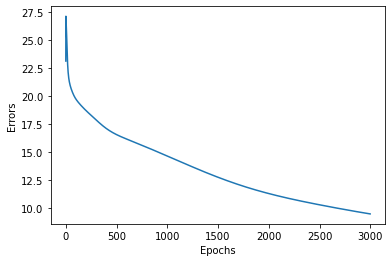

In [33]:
def plot_error(model):
    plt.plot(range(len(model.error_)), model.error_)
    plt.xlabel('Epochs')
    plt.ylabel('Errors')
    plt.show()
    
plot_error(nn)

In [34]:
y_train_prediction = nn.predict(X_train)
y_test_prediction = nn.predict(X_test)
y_prediction = nn.predict(X_val)

### Matrice de confusion ensemble "train"

In [35]:
print(confusion_matrix(y_train,y_train_prediction))
print(classification_report(y_train,y_train_prediction))

[[110   6   0   2   0   3   0   0]
 [  1 102   2   1   1   5   1   0]
 [  5   1  46   3   9   3   3   2]
 [  8   1   3  63   2  10   3   4]
 [  8   1   3   0  75   5   1   1]
 [  2   1   0   1   1  81   0   0]
 [  2   0  12   2   3   1  82   1]
 [  3   0   2  13   5   5  15  42]]
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       121
           1       0.91      0.90      0.91       113
           2       0.68      0.64      0.66        72
           3       0.74      0.67      0.70        94
           4       0.78      0.80      0.79        94
           5       0.72      0.94      0.81        86
           6       0.78      0.80      0.79       103
           7       0.84      0.49      0.62        85

    accuracy                           0.78       768
   macro avg       0.78      0.77      0.77       768
weighted avg       0.79      0.78      0.78       768



### Matrice de confusion ensemble "test"

In [36]:
print(confusion_matrix(y_test,y_test_prediction))
print(classification_report(y_test,y_test_prediction))

[[15  1  0 16  2  3  1  0]
 [12  6  2  9  3  2  0  4]
 [ 5  0 19  5  1  2  0  1]
 [ 0  0  0 13  1  5  1  9]
 [ 3  1  0 15  2  3  1  3]
 [ 3  0  0  5  1  9  0  0]
 [ 0  0  3  3  0  1 10 11]
 [ 0  1  0  7  0  0  6 15]]
              precision    recall  f1-score   support

           0       0.39      0.39      0.39        38
           1       0.67      0.16      0.26        38
           2       0.79      0.58      0.67        33
           3       0.18      0.45      0.25        29
           4       0.20      0.07      0.11        28
           5       0.36      0.50      0.42        18
           6       0.53      0.36      0.43        28
           7       0.35      0.52      0.42        29

    accuracy                           0.37       241
   macro avg       0.43      0.38      0.37       241
weighted avg       0.45      0.37      0.37       241



### Matrice de confusion ensemble "Val"

In [37]:
print(confusion_matrix(y_val,y_prediction))
print(classification_report(y_val,y_prediction))

[[16  4  0  1  1  1  2  0]
 [ 2 18  0  2  0  1  1  0]
 [ 3  0  7  5  2  0  6  2]
 [ 3  5  1  6  1  1  2  3]
 [ 6  1  0  9  6  1  0  2]
 [ 2  7  0  4  1  9  1  1]
 [ 7  0  1  4  5  1 14  1]
 [ 0  0  1  6  0  2  4  1]]
              precision    recall  f1-score   support

           0       0.41      0.64      0.50        25
           1       0.51      0.75      0.61        24
           2       0.70      0.28      0.40        25
           3       0.16      0.27      0.20        22
           4       0.38      0.24      0.29        25
           5       0.56      0.36      0.44        25
           6       0.47      0.42      0.44        33
           7       0.10      0.07      0.08        14

    accuracy                           0.40       193
   macro avg       0.41      0.38      0.37       193
weighted avg       0.43      0.40      0.39       193



## Support Vector Machine (SVM lineair)

In [38]:
svc = SVC(cache_size=1500)
parameter = {'kernel': ['linear'], 'C': [0.001, 0.1, 1, 10], 'class_weight': ['balanced'], 'gamma': ['scale']}
classifier = GridSearchCV(svc, param_grid = parameter, cv = 10, n_jobs = 5, scoring = 'accuracy', verbose=4)
classifier.fit(X_train, y_train)
print("LINEAR : The best hyperparameters are %s with a score of %0.2f" % (classifier.best_params_, classifier.best_score_))

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


LINEAR : The best hyperparameters are {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'} with a score of 0.54


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done  40 out of  40 | elapsed:    1.3s finished


Nous avons constaté qu'augmenter la grosseur de la cache ne changeait pas nos résultats, alors nous l'avons gardé à 1500.

In [39]:
SVMaccuracy = pd.DataFrame(classifier.cv_results_['mean_test_score'], index = [x['C'] for x  in classifier.cv_results_['params']], columns = ['SVM accuracy'])
print(SVMaccuracy)

        SVM accuracy
0.001       0.117157
0.100       0.361859
1.000       0.481630
10.000      0.540362


## K-Nearest Neighbor (KNN)

In [40]:
# K-Nearest Neighbor 
def KNN_model (X_train, X_test, y_train, y_test, weights):
    
    KNN_accuracy_uniform = []
    KNN_f1_uniform = []
    
    KNNParams = [3,5,10]

    for neighbors in KNNParams:

        model = KNeighborsClassifier(n_neighbors = neighbors, weights = weights)
        KNNmodel = model.fit(X_train, y_train)
        y_prediction = KNNmodel.predict(X_test)
        
        # Calculate the accuracy of KNN
        accuracy = accuracy_score(y_test, y_prediction)
        f1score = f1_score(y_test, y_prediction, average = 'weighted') 

        KNN_accuracy_uniform.append(accuracy)
        KNN_f1_uniform.append(f1score)
        
        # Print the F1 score
        print("F1 score : KNN")
        print(f1_score(y_test, y_prediction, average = 'weighted'))
        
        # Print the accuracy score
        print("Accuracy score : KNN avec k = " + str(neighbors) + " et poid = " + weights)
        print(KNNmodel.score(X_test, y_test))
        
        clf  = KNeighborsClassifier(n_neighbors = neighbors, weights = 'distance')
        
        ## KNN - Cross-validation
        print("Cross-validation")
        KNN_scores = cross_val_score(clf , X, y, cv = 10)
        print(sum(KNN_scores) / 10)
        print('\n')

In [41]:
KNN_model(X_train, X_test, y_train, y_test, 'uniform')
KNN_model(X_train, X_test, y_train, y_test, 'distance')

F1 score : KNN
0.2761920000373583
Accuracy score : KNN avec k = 3 et poid = uniform
0.2863070539419087
Cross-validation
0.6240082644628099


F1 score : KNN
0.3065132871851421
Accuracy score : KNN avec k = 5 et poid = uniform
0.3278008298755187
Cross-validation
0.6448209366391184


F1 score : KNN
0.37679312844380736
Accuracy score : KNN avec k = 10 et poid = uniform
0.37344398340248963
Cross-validation
0.6680716253443526


F1 score : KNN
0.3468848834831314
Accuracy score : KNN avec k = 3 et poid = distance
0.3360995850622407
Cross-validation
0.6240082644628099


F1 score : KNN
0.36637971178842127
Accuracy score : KNN avec k = 5 et poid = distance
0.36099585062240663
Cross-validation
0.6448209366391184


F1 score : KNN
0.4095254729642526
Accuracy score : KNN avec k = 10 et poid = distance
0.3941908713692946
Cross-validation
0.6680716253443526




## Réseaux de neurones (RN)

In [47]:
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
mlp.fit(X, y)

C:\Users\jayyb\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

In [43]:
y_test_prediction = mlp.predict(X_test)
y_train_prediction = mlp.predict(X_train)
y_prediction = mlp.predict(X_val)

### Matrice de confusion ensemble "train"

In [44]:
print(confusion_matrix(y_train,y_train_prediction))
print(classification_report(y_train,y_train_prediction))

[[ 1  0 69 13 18  0 20  0]
 [ 0  0 14 10 84  0  5  0]
 [ 0  0 64  5  1  0  2  0]
 [ 2  0 67  5  4  0 15  1]
 [ 1  0 83  6  3  0  1  0]
 [ 0  0 74  6  4  0  2  0]
 [ 2  0 48 18  3  0 31  1]
 [ 0  0 51 16  2  0 15  1]]
              precision    recall  f1-score   support

           0       0.17      0.01      0.02       121
           1       0.00      0.00      0.00       113
           2       0.14      0.89      0.24        72
           3       0.06      0.05      0.06        94
           4       0.03      0.03      0.03        94
           5       0.00      0.00      0.00        86
           6       0.34      0.30      0.32       103
           7       0.33      0.01      0.02        85

    accuracy                           0.14       768
   macro avg       0.13      0.16      0.09       768
weighted avg       0.13      0.14      0.08       768



C:\Users\jayyb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Matrice de confusion ensemble "test"

In [45]:
print(confusion_matrix(y_test,y_test_prediction))
print(classification_report(y_test,y_test_prediction))

[[ 0  0 27  5  0  0  6  0]
 [ 1  0 16  5 11  0  5  0]
 [ 0  0 30  0  3  0  0  0]
 [ 1  0 23  3  0  0  1  1]
 [ 1  0 21  1  3  0  1  1]
 [ 0  0 16  2  0  0  0  0]
 [ 1  0 13  4  1  0  8  1]
 [ 0  0 22  1  0  0  5  1]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.00      0.00      0.00        38
           2       0.18      0.91      0.30        33
           3       0.14      0.10      0.12        29
           4       0.17      0.11      0.13        28
           5       0.00      0.00      0.00        18
           6       0.31      0.29      0.30        28
           7       0.25      0.03      0.06        29

    accuracy                           0.19       241
   macro avg       0.13      0.18      0.11       241
weighted avg       0.13      0.19      0.11       241



## Tableaux de comparaison pour les 3 modèles utilisés

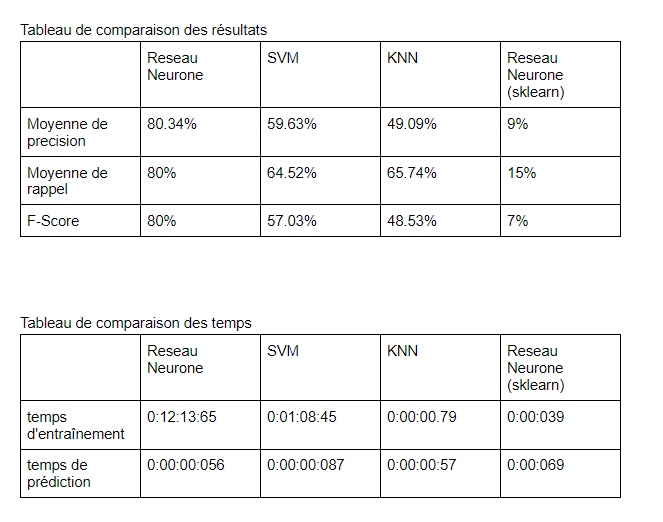

## Analyse des résultats 

Avec les tests sur nos modèles, nous avons pu constater que certains modèles avaient de meilleurs résultats que d'autre. Nous avons essayé d'optimiser les résultats avec les hyperparamètre mais, de nos expériences, nous avons trouvé que notre réseau de neurone était le plus efficace.


## Conclusion et intreprétation des résultats

Pour conclure, nous avons réussi à faire un modèle d'apprentissage machine en fonction des notions vue en cours. Nous avons remarqué que , dépendament du models, les hyperparamètres peuvent  varié et avoir des effets differents. Cela nous démontre l'importance de choisir un bon modèle en fonction dude la situation qu'on veut résoudre, car un mauvais choix de modèle peut s'avérer catastrophique. Ce laboratoire nous a permis d'appliquer nos nouvelles connaissances vue en classe et de les approfondirs. Il nous a aussi permi d'apprendre l'importance d'un bon choix pour les modèles sélectionner en fonction de la situation et l'importance d'une bonne décision face aux hyperparamètres.